In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii_2.sqlite")

In [5]:
# reflect an existing database into a new model
#set base as an automap base rather than declarative
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [23]:
# View all of the classes that automap found
#call classes.keys to get the string names of the classes
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
#saving as a variable that matches the class name for consistency
Measurement = Base.classes.measurement
Station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [26]:
# Exploratory Precipitation Analysis
# Create the inspector and connect it to the engine
inspector = inspect(engine)

#check the column names in the data set in order to write the queries
measurement_col = inspector.get_columns('measurement')

for col in measurement_col:
    print (col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [27]:
#repeat for station
station_col = inspector.get_columns('station')

for col in station_col:
    print (col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [31]:
# Find the most recent date in the data set.
#use order by for the date column and print the 0th element in the list to get the most recent date
final_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Dataset End Date: {final_date[0]}")

Dataset End Date: 2017-08-23


In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set as the starting point for the 12 month period 
#you could just hard code the end date in the y-m-d format but then the code wouldnt update to show a moving 1 year graph as new data is added
one_ya = (dt.datetime.strptime(final_date[0], '%Y-%m-%d')- dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"Dataset start date is:{one_ya}")

Dataset start date is:2016-08-23


In [38]:
# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_ya).all()
# check query before building dataframe 
prcp_query[0]

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_query)
prcp_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [42]:
# Sort the dataframe by date
#set the date to the index and sort ascending to begin the chart at the earliest date (like a timeline)
prcp_df.set_index('date')
prcp_asc_df = prcp_df.sort_index(ascending =  True)
prcp_asc_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


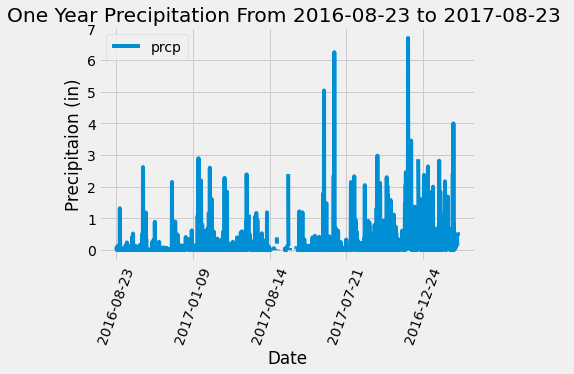

In [56]:
# Use Pandas Plotting with Matplotlib to plot the data
#specify the date and prcp for x and y axis
prcp_df.plot('date', 'prcp', rot=70)
#need to do some formatting
#building in flexibility to the title will allow an evergreen one year record
plt.title (f'One Year Precipitation From {one_ya} to {final_date [0]} ')
plt.xlabel("Date")
plt.ylabel("Precipitaion (in)")
plt.legend()
plt.show()

In [41]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#simple .describe operation
prcp_asc_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [59]:
# Design a query to calculate the total number stations in the dataset
#using station data set, query the id bc it is the primary key so will return the unique values
station_count = session.query(Station.id).count()
station_count

9

In [76]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
# need to use the measurement data set and group by station and then count number of appearances 
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [78]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# save the first row and column in the station activity variable into its own variable to get the station for queries 
most_active = station_activity[0][0]
most_active

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()


[(54.0, 85.0, 71.66378066378067)]

In [71]:
#filter measurement data to only view station, date and temps
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#use the most active station variable to filter for only that station and one_ya date filter 
temp_data = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == most_active).\
            filter(Measurement.date >= one_ya).all()
temp_df = pd.DataFrame(temp_data)
temp_df.head(15)

,station,date,tobs
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0
5,USC00519281,2016-08-28,73.0
6,USC00519281,2016-08-29,78.0
7,USC00519281,2016-08-30,77.0
8,USC00519281,2016-08-31,78.0
9,USC00519281,2016-09-01,80.0


In [15]:
#histogram



# Close session

In [16]:
# Close Session
session.close()